In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_olivetti_faces
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the Olivetti dataset
data = fetch_olivetti_faces()
images = data.images
images = images.reshape(images.shape[0], 1, 64, 64).astype('float32')
images = torch.tensor(images)

# Split data into training and testing sets
X_train, X_test = train_test_split(images, test_size=0.2, random_state=42)

# Create DataLoaders
train_loader = DataLoader(X_train, batch_size=32, shuffle=True)
test_loader = DataLoader(X_test, batch_size=32, shuffle=False)

/home/smithtape/anaconda3/envs/envtwo/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define the Convolutional Autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [3]:
# Initialize model, loss function, and optimizer
model = ConvAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [4]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

In [5]:
# Train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for data in train_loader:  # Change here, only expect data
            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, data)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)
        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data in val_loader:  # Change here, only expect data
                data = data.to(device)
                outputs = model(data)
                loss = criterion(outputs, data)
                val_loss += loss.item() * data.size(0)
        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, val_loss))

    return train_losses, val_losses


In [6]:
# Train the model
train_losses, val_losses = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=200)

Epoch: 0 	Training Loss: 0.028700 	Validation Loss: 0.026494
Epoch: 1 	Training Loss: 0.023064 	Validation Loss: 0.022518
Epoch: 2 	Training Loss: 0.019128 	Validation Loss: 0.017747
Epoch: 3 	Training Loss: 0.015600 	Validation Loss: 0.015231
Epoch: 4 	Training Loss: 0.013029 	Validation Loss: 0.012440
Epoch: 5 	Training Loss: 0.011009 	Validation Loss: 0.010305
Epoch: 6 	Training Loss: 0.009510 	Validation Loss: 0.008737
Epoch: 7 	Training Loss: 0.008374 	Validation Loss: 0.007658
Epoch: 8 	Training Loss: 0.007552 	Validation Loss: 0.006849
Epoch: 9 	Training Loss: 0.006800 	Validation Loss: 0.006312
Epoch: 10 	Training Loss: 0.006226 	Validation Loss: 0.005522
Epoch: 11 	Training Loss: 0.005671 	Validation Loss: 0.005220
Epoch: 12 	Training Loss: 0.005372 	Validation Loss: 0.004828
Epoch: 13 	Training Loss: 0.005055 	Validation Loss: 0.004478
Epoch: 14 	Training Loss: 0.004702 	Validation Loss: 0.004192
Epoch: 15 	Training Loss: 0.004428 	Validation Loss: 0.003996
Epoch: 16 	Trainin

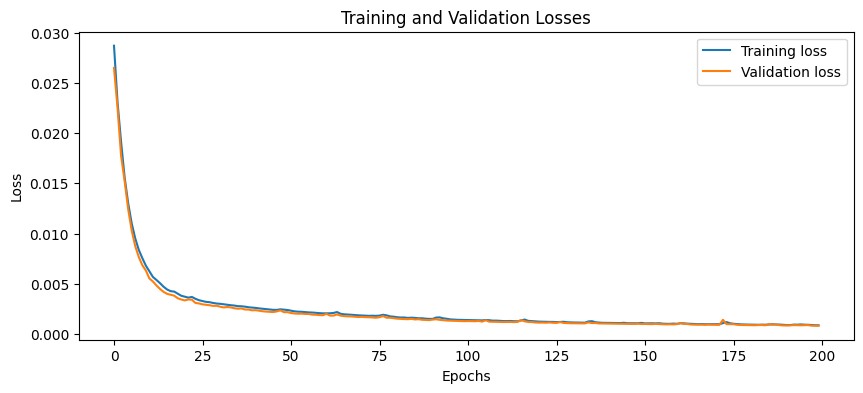

In [7]:
# Plot training and validation losses
plt.figure(figsize=(10,4))
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [8]:
# Extract features from the encoder
def extract_features(model, data_loader):
    model.eval()
    features = []
    with torch.no_grad():
        for data in data_loader:  # Only expect data
            data = data.to(device)
            encoded = model.encoder(data)
            features.append(encoded.cpu().numpy())
    return np.concatenate(features)

# Extract encoded features
encoded_train = extract_features(model, train_loader)
encoded_test = extract_features(model, test_loader)  # Use test_loader instead of val_loader

# Flatten encoded features for K-Means
n_samples_train = encoded_train.shape[0]
n_samples_test = encoded_test.shape[0]
encoded_train_flat = encoded_train.reshape(n_samples_train, -1)
encoded_test_flat = encoded_test.reshape(n_samples_test, -1)


In [9]:
import numpy as np

class KMeans:
    def __init__(self, n_clusters=3, max_iter=100, random_state=42):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
        self.centroids = None

    def fit(self, X):
        np.random.seed(self.random_state)
        random_idx = np.random.permutation(X.shape[0])
        self.centroids = X[random_idx[:self.n_clusters]]

        for _ in range(self.max_iter):
            self.labels_ = self._assign_labels(X)
            new_centroids = self._compute_centroids(X)

            if np.all(new_centroids == self.centroids):
                break

            self.centroids = new_centroids

        return self

    def _assign_labels(self, X):
        distances = self._compute_distances(X)
        return np.argmin(distances, axis=1)

    def _compute_distances(self, X):
        distances = []
        for centroid in self.centroids:
            distance = np.sqrt(((X - centroid) ** 2).sum(axis=1))
            distances.append(distance)
        return np.array(distances).T

    def _compute_centroids(self, X):
        centroids = []
        for i in range(self.n_clusters):
            centroids.append(X[self.labels_ == i].mean(axis=0))
        return np.array(centroids)

    def predict(self, X):
        if self.centroids is None:
            raise ValueError("Model is not yet fitted.")
        return self._assign_labels(X)

# Usage
kmeans = KMeans(n_clusters=10, max_iter=3000)
kmeans.fit(encoded_train_flat)  # assuming encoded_train_flat is your data
predicted_labels = kmeans.predict(encoded_test_flat)  # assuming encoded_test_flat is your data


In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Applying t-SNE to reduce dimensions to 2
tsne = TSNE(n_components=2, random_state=42)
encoded_train_tsne = tsne.fit_transform(encoded_train_flat)  # Assuming encoded_train_flat is your data


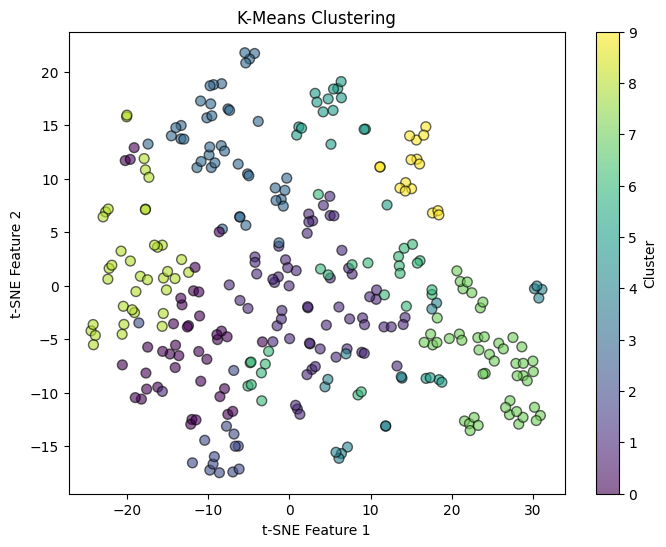

In [11]:
def plot_clusters(data, labels, title='K-Means Clustering'):
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.6)
    plt.title(title)
    plt.xlabel('t-SNE Feature 1')
    plt.ylabel('t-SNE Feature 2')
    plt.colorbar(label='Cluster')
    plt.show()

# Plotting
plot_clusters(encoded_train_tsne, kmeans.labels_)


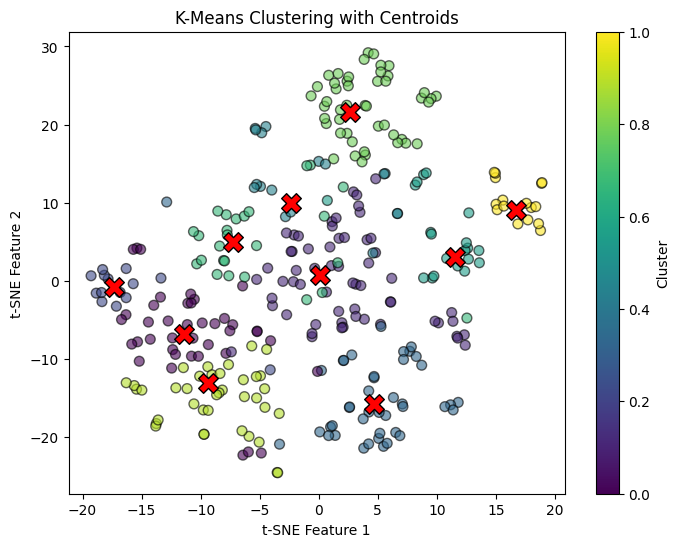

In [12]:
def plot_clusters_with_centroids(data, labels, centroids, title='K-Means Clustering with Centroids'):
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.6)
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', edgecolor='k', s=200)
    plt.title(title)
    plt.xlabel('t-SNE Feature 1')
    plt.ylabel('t-SNE Feature 2')
    plt.colorbar(label='Cluster')
    plt.show()

# Concatenating the centroids to the dataset
combined_data = np.vstack([encoded_train_flat, kmeans.centroids])

# Running t-SNE on the combined dataset
tsne = TSNE(n_components=2, random_state=42)
combined_tsne = tsne.fit_transform(combined_data)

# Separating the transformed data and centroids
data_tsne = combined_tsne[:-kmeans.n_clusters, :]
centroids_tsne = combined_tsne[-kmeans.n_clusters:, :]

# Plotting
plot_clusters_with_centroids(data_tsne, kmeans.labels_, centroids_tsne)


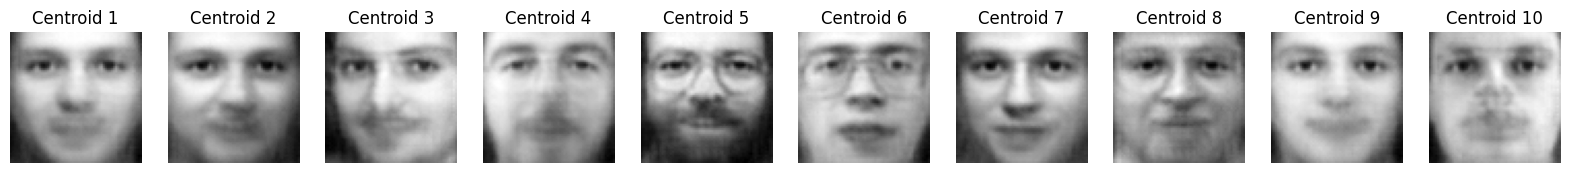

In [13]:
import matplotlib.pyplot as plt
import torch

def reconstruct_from_centroids(centroids, decoder, input_shape, device):
    # Convert centroids to PyTorch tensors and reshape
    centroids_tensor = torch.tensor(centroids, dtype=torch.float32).to(device)
    centroids_tensor = centroids_tensor.view(-1, *input_shape)  # Reshape to the expected input shape of the decoder

    # Reconstruct images using the decoder
    reconstructed_imgs = decoder(centroids_tensor).cpu().detach().numpy()

    return reconstructed_imgs

# Replace 'input_shape' with the expected input shape of the decoder.
# For example, if the decoder expects input of shape [channels, height, width],
# and assuming the encoder output was flattened to a size of 6400,
# the shape might be something like [64, 10, 10] (this is just an example and will depend on your model architecture).
input_shape = (64, 10, 10)  # Modify this according to your model's architecture

reconstructed_imgs = reconstruct_from_centroids(kmeans.centroids, model.decoder, input_shape, device)

# Visualize the reconstructed images
fig, axes = plt.subplots(1, len(reconstructed_imgs), figsize=(20, 4))
for i, ax in enumerate(axes):
    ax.imshow(reconstructed_imgs[i].reshape(64, 64), cmap='gray')
    ax.axis('off')
    ax.set_title(f'Centroid {i+1}')
plt.show()



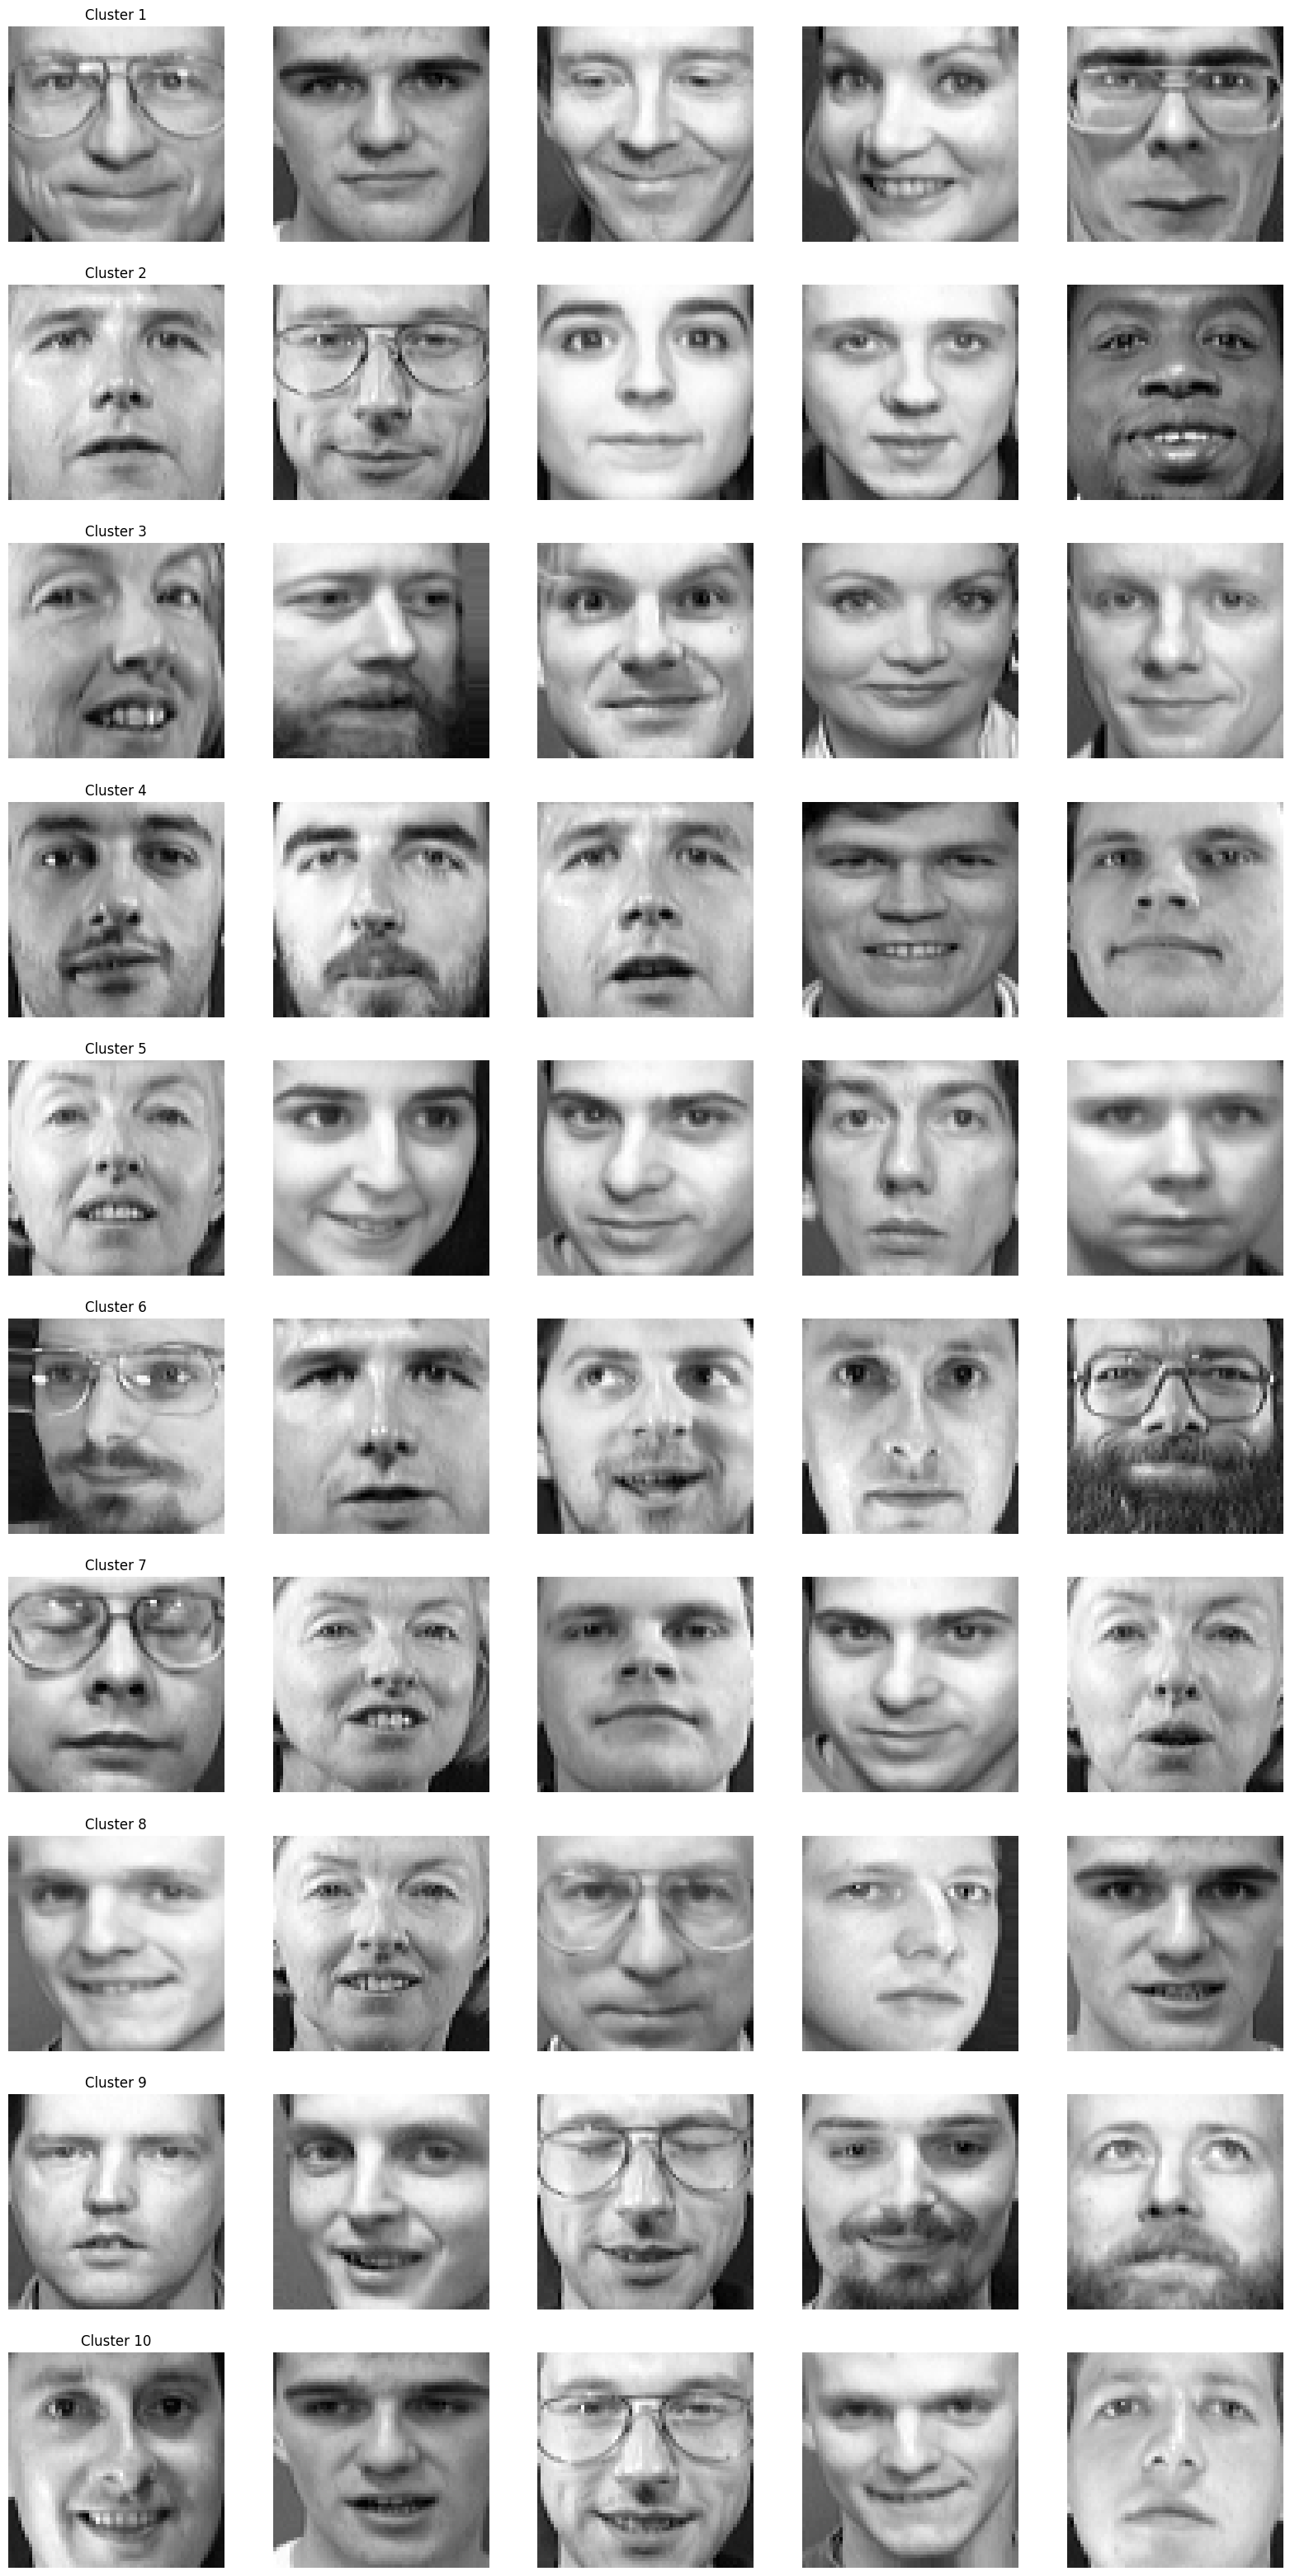

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images_from_clusters(X, labels, n_clusters, images_per_cluster=10):
    plt.figure(figsize=(20, 4 * n_clusters))
    
    for i in range(n_clusters):
        cluster_indices = np.where(labels == i)[0]
        
        # If the cluster has fewer images than images_per_cluster, select all images from that cluster
        if len(cluster_indices) < images_per_cluster:
            selected_indices = cluster_indices
        else:
            selected_indices = np.random.choice(cluster_indices, images_per_cluster, replace=False)
        
        for j, idx in enumerate(selected_indices):
            plt_index = i * images_per_cluster + j + 1
            plt.subplot(n_clusters, images_per_cluster, plt_index)
            plt.imshow(X[idx].reshape(64, 64), cmap='gray')
            plt.axis('off')
            if j == 0:
                plt.title(f"Cluster {i+1}")

    plt.show()

# Assuming 'X_train' is your dataset and 'kmeans.labels_' are your cluster labels
plot_images_from_clusters(X_train, kmeans.labels_, n_clusters=kmeans.n_clusters, images_per_cluster=5)
